In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

In [74]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.o = dict()  # orders per data (main, stop, limit, manual-close)
        self.holding = dict()  # holding periods per data

    def notify_order(self, order):
        if order.status == order.Submitted:
            return

        dt, dn = self.datetime.date(), order.data._name
        print('{} {} Order {} Price {} Status {}'.format(
            dt, dn, order.ref, order.executed.price, order.getstatusname())
        )

        whichord = ['main', 'stop', 'limit', 'close']
        if not order.alive():  # not alive - nullify
            dorders = self.o[order.data]
            idx = dorders.index(order)
            dorders[idx] = None
            print('-- No longer alive {} Ref'.format(whichord[idx]))

            if all(x is None for x in dorders):
                dorders[:] = []  # empty list - New orders allowed

                
        # if order.status in [order.Submitted, order.Accepted]:
        #     # Buy/Sell order submitted/accepted to/by broker - Nothing to do
        #     return

        # # Check if an order has been completed
        # # Attention: broker could reject order if not enough cash
        # if order.status in [order.Completed]:
        #     if order.isbuy():
        #         self.log('BUY EXECUTED, %.2f' % order.executed.price)
        #     elif order.issell():
        #         self.log('SELL EXECUTED, %.2f' % order.executed.price)

        #     self.bar_executed = len(self)

        # elif order.status in [order.Canceled, order.Margin, order.Rejected]:
        #     self.log('Order Canceled/Margin/Rejected')

        # # Write down: no pending order
        # self.order = None

    def next(self):
        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.date(), d._name
            pos = self.getposition(d).size
            # if dn == "AAPL":
            print('{} {} Position {}'.format(dt, dn, pos))
            # print(f'Close: {d.close[0]}')

            if not pos and not self.o.get(d, None):  # no market / no orders
                if dn == "AAPL":
                    self.o[d] = [self.buy(data=d)]
                    print('{} {} Buy {}'.format(dt, dn, self.o[d][0].ref))
                    self.holding[d] = 0
                # if dt.weekday() == self.p.enter[i]:
                #     if not self.p.usebracket:
                #         self.o[d] = [self.buy(data=d)]
                #         print('{} {} Buy {}'.format(dt, dn, self.o[d][0].ref))

                #     else:
                #         p = d.close[0] * (1.0 - self.p.pentry)
                #         pstp = p * (1.0 - self.p.plimits)
                #         plmt = p * (1.0 + self.p.plimits)
                #         valid = datetime.timedelta(self.p.valid)

                #         if self.p.rawbracket:
                #             o1 = self.buy(data=d, exectype=bt.Order.Limit,
                #                           price=p, valid=valid, transmit=False)

                #             o2 = self.sell(data=d, exectype=bt.Order.Stop,
                #                            price=pstp, size=o1.size,
                #                            transmit=False, parent=o1)

                #             o3 = self.sell(data=d, exectype=bt.Order.Limit,
                #                            price=plmt, size=o1.size,
                #                            transmit=True, parent=o1)

                #             self.o[d] = [o1, o2, o3]

                #         else:
                #             self.o[d] = self.buy_bracket(
                #                 data=d, price=p, stopprice=pstp,
                #                 limitprice=plmt, oargs=dict(valid=valid))

                #         print('{} {} Main {} Stp {} Lmt {}'.format(
                #             dt, dn, *(x.ref for x in self.o[d])))

                #     self.holding[d] = 0

            elif pos:  # exiting can also happen after a number of days
                self.holding[d] += 1
                if self.holding[d] >= 5:
                    o = self.sell(data=d)
                    self.o[d].append(o)  # manual order to list of orders
                    print('{} {} Manual Close {}'.format(dt, dn, o.ref))
                    # if self.p.usebracket:
                    #     self.cancel(self.o[d][1])  # cancel stop side
                    #     print('{} {} Cancel {}'.format(dt, dn, self.o[d][1]))
                        
        # # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.dataclose[0])

        # # Check if an order is pending ... if yes, we cannot send a 2nd one
        # if self.order:
        #     return

        # # Check if we are in the market
        # if not self.position:

        #     # Not yet ... we MIGHT BUY if ...
        #     if self.dataclose[0] < self.dataclose[-1]:
        #             # current close less than previous close

        #             if self.dataclose[-1] < self.dataclose[-2]:
        #                 # previous close less than the previous close

        #                 # BUY, BUY, BUY!!! (with default parameters)
        #                 self.log('BUY CREATE, %.2f' % self.dataclose[0])

        #                 # Keep track of the created order to avoid a 2nd order
        #                 self.order = self.buy(data="AAPL", size=2)

        # else:

        #     # Already in the market ... we might sell
        #     if len(self) >= (self.bar_executed + 5):
        #         # SELL, SELL, SELL!!! (with all possible default parameters)
        #         self.log('SELL CREATE, %.2f' % self.dataclose[0])

        #         # Keep track of the created order to avoid a 2nd order
        #         self.order = self.sell(data="AAPL", size=1)

In [24]:
df = pd.read_csv("./data/nasdaq100_stock_prices.csv", parse_dates=["date"], index_col=0)

In [25]:
df.set_index("date", inplace=True)
tickers = df["ticker"].unique()

In [26]:
df.head()

open      close       high        low   volume ticker  \
date                                                                     
2005-01-03  31.493821  30.838949  31.743772  30.768963  5508800   ADBE   
2005-01-04  31.098899  30.024111  31.183883  29.674179  7515400   ADBE   
2005-01-05  30.084099  29.859142  30.444029  29.859142  3566600   ADBE   
2005-01-06  30.109092  29.364239  30.164081  29.239263  6159600   ADBE   
2005-01-07  29.499211  29.384233  29.749162  28.844340  8512400   ADBE   

               company                  sector  
date                                            
2005-01-03  Adobe Inc.  Information Technology  
2005-01-04  Adobe Inc.  Information Technology  
2005-01-05  Adobe Inc.  Information Technology  
2005-01-06  Adobe Inc.  Information Technology  
2005-01-07  Adobe Inc.  Information Technology

In [122]:
def feed_data(start_date, end_date):
    data_feeds = []
    for ticker in tickers:
        df_ticker = df[df["ticker"] == ticker].drop(columns=["ticker"])
        
        # Check if stock has data within the desired period
        # if df_ticker.index.min() <= start_date and df_ticker.index.max() >= end_date:
        data = bt.feeds.PandasData(
            dataname=df_ticker,
            # fromdate=start_date,
            # todate=end_date
        )
        data_feeds.append((ticker, data))
    return data_feeds

In [123]:
start_date = datetime.datetime(2005, 1, 3)
end_date = datetime.datetime(2024, 12, 31)
data_feeds = feed_data(start_date, end_date)

In [124]:
len(data_feeds)

101

In [84]:
STOCK = "AAPL"

In [101]:
import matplotlib.pyplot as pl
from IPython.display import Image

def save_plot(img_path):
    pl.style.use("default") #ggplot is also fine
    pl.rcParams["figure.figsize"] = (25,17)
    
    # Generate the plot
    figs = cerebro.plot(style="candlestick")  # Returns a list of figures
    
    # Extract the first figure correctly
    fig = figs[0][0]  # First figure from the first subplot
    
    # Save the figure
    fig.savefig(img_path)  # Save with high resolution
    
    # Display the saved image
    Image(filename=img_path)

In [116]:
class BuyAndHoldStrategy(bt.Strategy):
    def __init__(self):
        pass  # No indicators needed

    def next(self):
        if self.position.size == 0:  # Buy only at the start
            self.buy()

cerebro = bt.Cerebro()
cerebro.addstrategy(BuyAndHoldStrategy)

for ticker, data in data_feeds:
    if (ticker == STOCK):
        cerebro.adddata(data, name=ticker)
    
cerebro.broker.setcash(100000.0)

cerebro.addsizer(bt.sizers.AllInSizer)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")


print('Buy and Hold Strategy')
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

sharpe_ratio = results[0].analyzers.sharpe.get_analysis()
drawdown = results[0].analyzers.drawdown.get_analysis()

img_path = "buyandhold.png"
# save_plot(img_path)

print(f"Sharpe Ratio: {sharpe_ratio['sharperatio']}")
print(f"Max Drawdown: {drawdown['max']['drawdown']}%")


Buy and Hold Strategy
Starting Portfolio Value: 100000.00
Final Portfolio Value: 24108415.86
Sharpe Ratio: 0.8046097835557823
Max Drawdown: 60.75877896322654%


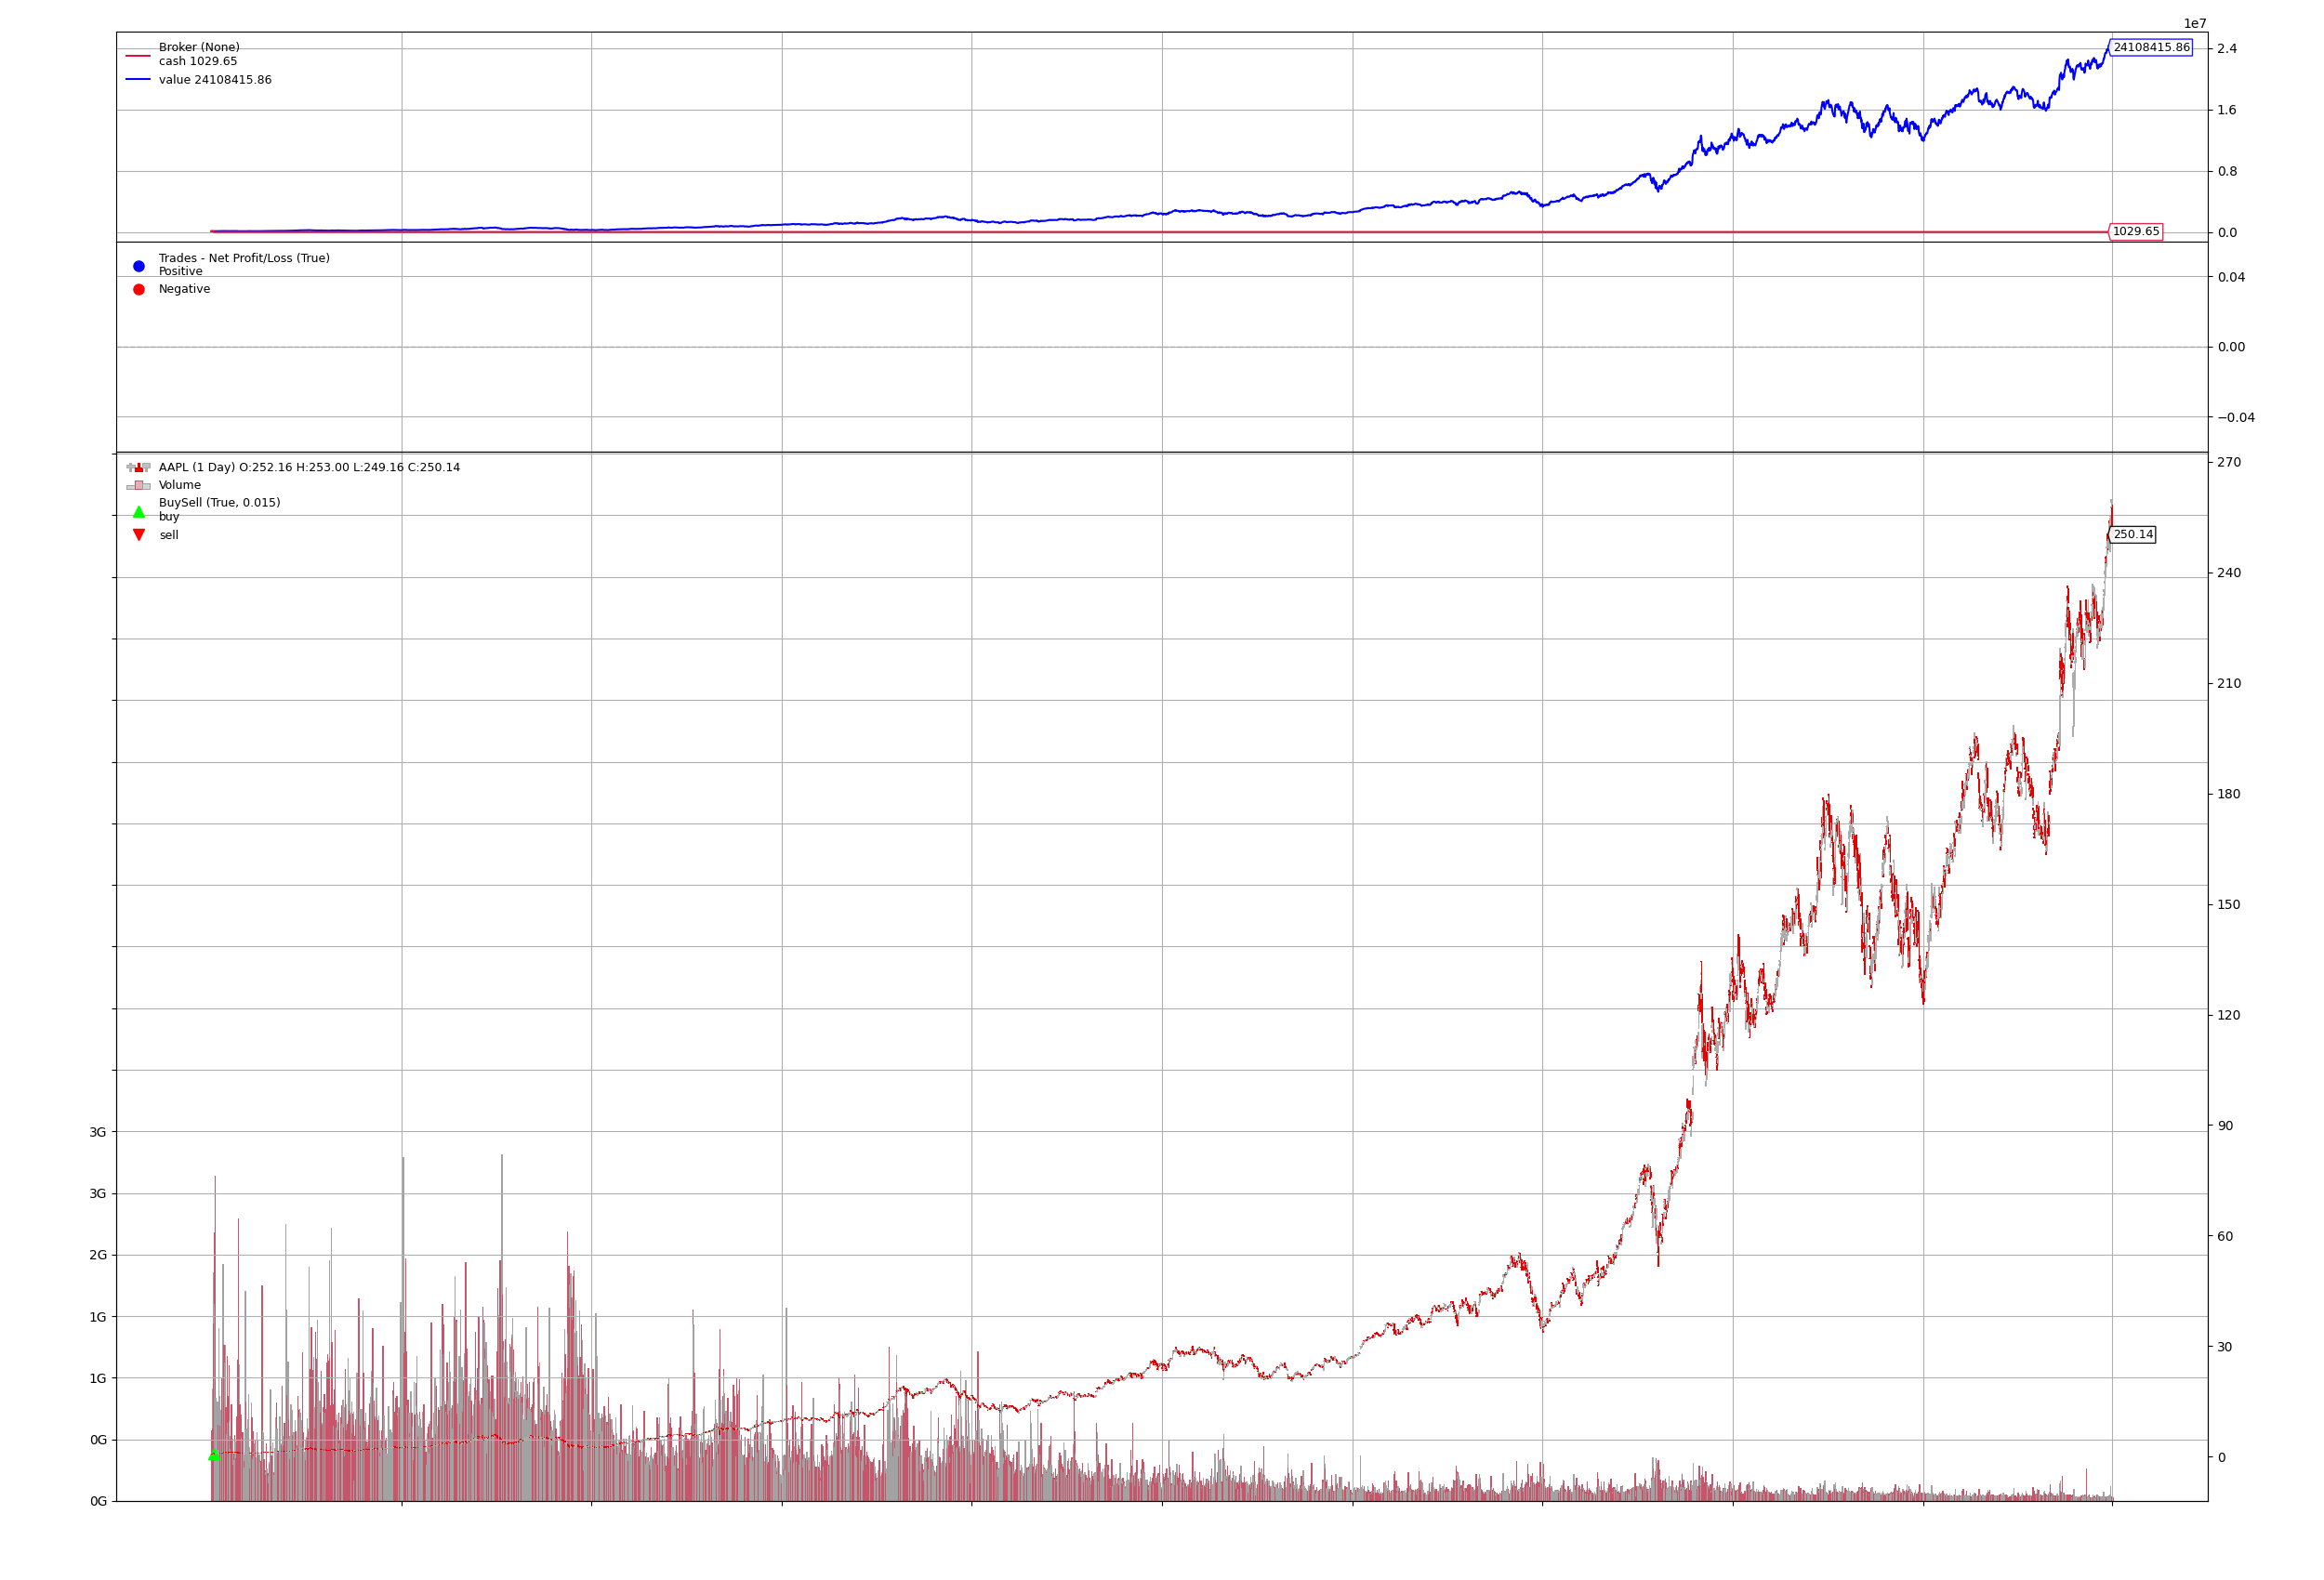

In [111]:
Image(img_path)

In [129]:
class DualMovingAverageStrategy(bt.SignalStrategy):
    params = (
        ('smavg_window', 100),
        ('lmavg_window', 300),
    )

    def __init__(self):

        # Compute long and short moving averages
        smavg = bt.ind.SMA(period=self.p.smavg_window)
        lmavg = bt.ind.SMA(period=self.p.lmavg_window)

        # Go long when short moving average is above long moving average
        self.signal_add(bt.SIGNAL_LONG, bt.ind.CrossOver(smavg, lmavg))

def run_dma(stock):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(MovingAverageCrossover)
    
    for ticker, data in data_feeds:
        if (ticker == stock):
            cerebro.adddata(data, name=ticker)
        
    cerebro.broker.setcash(100000.0)
    
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe")
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")
    
    
    print(f'Dual Moving Average Crossover Strategy: {stock}')
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    results = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    sharpe_ratio = results[0].analyzers.sharpe.get_analysis()
    drawdown = results[0].analyzers.drawdown.get_analysis()
    
    img_path = f"assets/dma/{stock}.png"
    figs = cerebro.plot(style="candlestick")  # Returns a list of figures
    
    # Extract the first figure correctly
    fig = figs[0][0]  # First figure from the first subplot
    
    # Save the figure
    fig.savefig(img_path)  # Save with high resolution
    
    print(f"Sharpe Ratio: {sharpe_ratio['sharperatio']}")
    print(f"Max Drawdown: {drawdown['max']['drawdown']}%")
    return {'sharpe': sharpe_ratio['sharperatio'], 'drawdown': drawdown['max']['drawdown']}

In [132]:
results = []
for ticker in tickers:
    ret = run_dma(ticker)
    ret['ticker'] = ticker
    results.append(ret)
    
exported_results = pd.DataFrame(results)

# Export to CSV
exported_results.to_csv("assets/dma/results.csv", index=False)  # index=False to avoid adding an extra column

Dual Moving Average Crossover Strategy: ADBE
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100029.60


<IPython.core.display.Javascript object>

Sharpe Ratio: -15.249162510197511
Max Drawdown: 0.3581963571344954%
Dual Moving Average Crossover Strategy: AMD
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100071.83


<IPython.core.display.Javascript object>

Sharpe Ratio: -49.28727092804847
Max Drawdown: 0.08047454968983368%
Dual Moving Average Crossover Strategy: ABNB
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99971.42


<IPython.core.display.Javascript object>

Sharpe Ratio: -32.07982775805088
Max Drawdown: 0.12065674642511022%
Dual Moving Average Crossover Strategy: GOOGL
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100100.51


<IPython.core.display.Javascript object>

Sharpe Ratio: -72.94179049298099
Max Drawdown: 0.06038478651655984%
Dual Moving Average Crossover Strategy: GOOG
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100102.14


<IPython.core.display.Javascript object>

Sharpe Ratio: -75.27276128392518
Max Drawdown: 0.05482013507739357%
Dual Moving Average Crossover Strategy: AMZN
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100070.51


<IPython.core.display.Javascript object>

Sharpe Ratio: -50.45738611698005
Max Drawdown: 0.11750743414303552%
Dual Moving Average Crossover Strategy: AEP
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100005.61


<IPython.core.display.Javascript object>

Sharpe Ratio: -130.91743402258157
Max Drawdown: 0.06115114616699421%
Dual Moving Average Crossover Strategy: AMGN
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100005.23


<IPython.core.display.Javascript object>

Sharpe Ratio: -50.39817537014023
Max Drawdown: 0.13510871667294638%
Dual Moving Average Crossover Strategy: ADI
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99992.19


<IPython.core.display.Javascript object>

Sharpe Ratio: -80.7115831625207
Max Drawdown: 0.07494577173487622%
Dual Moving Average Crossover Strategy: ANSS
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100007.62


<IPython.core.display.Javascript object>

Sharpe Ratio: -25.444225366683433
Max Drawdown: 0.21701215613680563%
Dual Moving Average Crossover Strategy: AAPL
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100152.17


<IPython.core.display.Javascript object>

Sharpe Ratio: -54.60730192450425
Max Drawdown: 0.049178180794625465%
Dual Moving Average Crossover Strategy: AMAT
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100065.79


<IPython.core.display.Javascript object>

Sharpe Ratio: -58.336175563772635
Max Drawdown: 0.08307549003681187%
Dual Moving Average Crossover Strategy: APP
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100261.82


<IPython.core.display.Javascript object>

Sharpe Ratio: -8.52439914642517
Max Drawdown: 0.08813079742759362%
Dual Moving Average Crossover Strategy: ARM
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100008.29


<IPython.core.display.Javascript object>

Sharpe Ratio: -104.83087666358563
Max Drawdown: 0.09605966933309369%
Dual Moving Average Crossover Strategy: ASML
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100340.13


<IPython.core.display.Javascript object>

Sharpe Ratio: -14.635655056060823
Max Drawdown: 0.43549381553281236%
Dual Moving Average Crossover Strategy: AZN
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100006.16


<IPython.core.display.Javascript object>

Sharpe Ratio: -326.1730853167769
Max Drawdown: 0.0164447917944742%
Dual Moving Average Crossover Strategy: TEAM
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100278.01


<IPython.core.display.Javascript object>

Sharpe Ratio: -34.583710929620366
Max Drawdown: 0.11044400606692946%
Dual Moving Average Crossover Strategy: ADSK
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100089.83


<IPython.core.display.Javascript object>

Sharpe Ratio: -39.07108790614278
Max Drawdown: 0.1715774748186231%
Dual Moving Average Crossover Strategy: ADP
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100140.34


<IPython.core.display.Javascript object>

Sharpe Ratio: -55.71236538163518
Max Drawdown: 0.05631021570006112%
Dual Moving Average Crossover Strategy: AXON
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100539.46


<IPython.core.display.Javascript object>

Sharpe Ratio: -12.181807054746864
Max Drawdown: 0.09485775111567972%
Dual Moving Average Crossover Strategy: BKR
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99998.25


<IPython.core.display.Javascript object>

Sharpe Ratio: -263.87133269747653
Max Drawdown: 0.026162347463763773%
Dual Moving Average Crossover Strategy: BIIB
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99827.82


<IPython.core.display.Javascript object>

Sharpe Ratio: -27.560529484588827
Max Drawdown: 0.4451533980662991%
Dual Moving Average Crossover Strategy: BKNG
Starting Portfolio Value: 100000.00
Final Portfolio Value: 101543.63


<IPython.core.display.Javascript object>

Sharpe Ratio: -2.1466570096700965
Max Drawdown: 1.741930614816946%
Dual Moving Average Crossover Strategy: AVGO
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100095.22


<IPython.core.display.Javascript object>

Sharpe Ratio: -73.30796536482582
Max Drawdown: 0.05388768145532888%
Dual Moving Average Crossover Strategy: CDNS
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100103.96


<IPython.core.display.Javascript object>

Sharpe Ratio: -51.95769188509915
Max Drawdown: 0.10448756274567059%
Dual Moving Average Crossover Strategy: CDW
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100111.38


<IPython.core.display.Javascript object>

Sharpe Ratio: -37.22284674552204
Max Drawdown: 0.06061733862460922%
Dual Moving Average Crossover Strategy: CHTR
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100232.60


<IPython.core.display.Javascript object>

Sharpe Ratio: -20.489869106846943
Max Drawdown: 0.26177863015836644%
Dual Moving Average Crossover Strategy: CTAS
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100138.55


<IPython.core.display.Javascript object>

Sharpe Ratio: -81.53841648645603
Max Drawdown: 0.04351992933474169%
Dual Moving Average Crossover Strategy: CSCO
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100023.67


<IPython.core.display.Javascript object>

Sharpe Ratio: -200.19738817155283
Max Drawdown: 0.015090460482479065%
Dual Moving Average Crossover Strategy: CCEP
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100038.65


<IPython.core.display.Javascript object>

Sharpe Ratio: -243.2864690721533
Max Drawdown: 0.018818899883849563%
Dual Moving Average Crossover Strategy: CTSH
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100003.12


<IPython.core.display.Javascript object>

Sharpe Ratio: -137.4493382429311
Max Drawdown: 0.04835492960161083%
Dual Moving Average Crossover Strategy: CMCSA
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100013.29


<IPython.core.display.Javascript object>

Sharpe Ratio: -267.2566151606108
Max Drawdown: 0.01377294595104882%
Dual Moving Average Crossover Strategy: CEG
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100146.27


<IPython.core.display.Javascript object>

Sharpe Ratio: -25.31928178553948
Max Drawdown: 0.06066839083713311%
Dual Moving Average Crossover Strategy: CPRT
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100034.77


<IPython.core.display.Javascript object>

Sharpe Ratio: -242.06654438878743
Max Drawdown: 0.011239520627092514%
Dual Moving Average Crossover Strategy: CSGP
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100048.27


<IPython.core.display.Javascript object>

Sharpe Ratio: -93.50730720718906
Max Drawdown: 0.03653131273691974%
Dual Moving Average Crossover Strategy: COST
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100399.23


<IPython.core.display.Javascript object>

Sharpe Ratio: -15.639597873051226
Max Drawdown: 0.22759046921218065%
Dual Moving Average Crossover Strategy: CRWD
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100062.52


<IPython.core.display.Javascript object>

Sharpe Ratio: -14.581566258929106
Max Drawdown: 0.15497027134326616%
Dual Moving Average Crossover Strategy: CSX
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100002.33


<IPython.core.display.Javascript object>

Sharpe Ratio: -357.5916534987613
Max Drawdown: 0.015260992164676251%
Dual Moving Average Crossover Strategy: DDOG
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100062.02


<IPython.core.display.Javascript object>

Sharpe Ratio: -40.97112930395434
Max Drawdown: 0.0764804027135757%
Dual Moving Average Crossover Strategy: DXCM
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100073.37


<IPython.core.display.Javascript object>

Sharpe Ratio: -109.74929279226757
Max Drawdown: 0.05688669960042891%
Dual Moving Average Crossover Strategy: FANG
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99988.53


<IPython.core.display.Javascript object>

Sharpe Ratio: -41.08476829244626
Max Drawdown: 0.11603702847664157%
Dual Moving Average Crossover Strategy: DASH
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99993.72


<IPython.core.display.Javascript object>

Sharpe Ratio: -23.717027572462992
Max Drawdown: 0.1403318637020792%
Dual Moving Average Crossover Strategy: EA
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99968.04


<IPython.core.display.Javascript object>

Sharpe Ratio: -67.97215837445022
Max Drawdown: 0.09517399357868883%
Dual Moving Average Crossover Strategy: EXC
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99998.54


<IPython.core.display.Javascript object>

Sharpe Ratio: -292.05442271550237
Max Drawdown: 0.01862925225377757%
Dual Moving Average Crossover Strategy: FAST
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100000.73


<IPython.core.display.Javascript object>

Sharpe Ratio: -151.09866739334737
Max Drawdown: 0.029342285632135794%
Dual Moving Average Crossover Strategy: FTNT
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100041.05


<IPython.core.display.Javascript object>

Sharpe Ratio: -72.61131764886024
Max Drawdown: 0.049295056980310115%
Dual Moving Average Crossover Strategy: GEHC
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100021.59


<IPython.core.display.Javascript object>

Sharpe Ratio: -149.60763701036913
Max Drawdown: 0.01671451588363674%
Dual Moving Average Crossover Strategy: GILD
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100053.40


<IPython.core.display.Javascript object>

Sharpe Ratio: -124.3516501099934
Max Drawdown: 0.028316992541959126%
Dual Moving Average Crossover Strategy: GFS
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99937.46


<IPython.core.display.Javascript object>

Sharpe Ratio: -69.67742809095171
Max Drawdown: 0.08585175543058078%
Dual Moving Average Crossover Strategy: HON
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100085.14


<IPython.core.display.Javascript object>

Sharpe Ratio: -47.78406648253562
Max Drawdown: 0.08770427193715565%
Dual Moving Average Crossover Strategy: IDXX
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100470.96


<IPython.core.display.Javascript object>

Sharpe Ratio: -18.161952152883764
Max Drawdown: 0.15617026339094017%
Dual Moving Average Crossover Strategy: INTC
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99982.37


<IPython.core.display.Javascript object>

Sharpe Ratio: -137.9697515288894
Max Drawdown: 0.044475863500604146%
Dual Moving Average Crossover Strategy: INTU
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100151.50


<IPython.core.display.Javascript object>

Sharpe Ratio: -15.412116596776448
Max Drawdown: 0.25421310320400375%
Dual Moving Average Crossover Strategy: ISRG
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100308.64


<IPython.core.display.Javascript object>

Sharpe Ratio: -20.628170442429802
Max Drawdown: 0.20445017045652875%
Dual Moving Average Crossover Strategy: KDP
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100012.49


<IPython.core.display.Javascript object>

Sharpe Ratio: -465.49651545303976
Max Drawdown: 0.00843802489723381%
Dual Moving Average Crossover Strategy: KLAC
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99878.66


<IPython.core.display.Javascript object>

Sharpe Ratio: -15.615086453288985
Max Drawdown: 0.3364119988424965%
Dual Moving Average Crossover Strategy: KHC
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99992.47


<IPython.core.display.Javascript object>

Sharpe Ratio: -171.7523531618576
Max Drawdown: 0.027571568792224867%
Dual Moving Average Crossover Strategy: LRCX
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100019.50


<IPython.core.display.Javascript object>

Sharpe Ratio: -101.5715301829954
Max Drawdown: 0.03813385335911955%
Dual Moving Average Crossover Strategy: LIN
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100127.16


<IPython.core.display.Javascript object>

Sharpe Ratio: -36.14722524137845
Max Drawdown: 0.12368061770444273%
Dual Moving Average Crossover Strategy: LULU
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100167.73


<IPython.core.display.Javascript object>

Sharpe Ratio: -22.81425691913619
Max Drawdown: 0.24842289271836027%
Dual Moving Average Crossover Strategy: MAR
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100105.21


<IPython.core.display.Javascript object>

Sharpe Ratio: -50.84313215100074
Max Drawdown: 0.06856868406337309%
Dual Moving Average Crossover Strategy: MRVL
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100075.44


<IPython.core.display.Javascript object>

Sharpe Ratio: -63.63824655861429
Max Drawdown: 0.05186336330421169%
Dual Moving Average Crossover Strategy: MELI
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100378.99


<IPython.core.display.Javascript object>

Sharpe Ratio: -3.779653289566849
Max Drawdown: 1.267159093384182%
Dual Moving Average Crossover Strategy: META
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100478.38


<IPython.core.display.Javascript object>

Sharpe Ratio: -15.198690776203728
Max Drawdown: 0.1468100746370776%
Dual Moving Average Crossover Strategy: MCHP
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99980.75


<IPython.core.display.Javascript object>

Sharpe Ratio: -89.00199089298124
Max Drawdown: 0.06623062841257098%
Dual Moving Average Crossover Strategy: MU
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100091.83


<IPython.core.display.Javascript object>

Sharpe Ratio: -86.16541638550197
Max Drawdown: 0.0430592301408823%
Dual Moving Average Crossover Strategy: MSFT
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100161.30


<IPython.core.display.Javascript object>

Sharpe Ratio: -30.402839492987937
Max Drawdown: 0.13705258184111022%
Dual Moving Average Crossover Strategy: MSTR
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100166.09


<IPython.core.display.Javascript object>

Sharpe Ratio: -35.86319264896381
Max Drawdown: 0.1835669619047269%
Dual Moving Average Crossover Strategy: MDLZ
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100008.32


<IPython.core.display.Javascript object>

Sharpe Ratio: -301.95717698000243
Max Drawdown: 0.012917688688502505%
Dual Moving Average Crossover Strategy: MDB
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100015.06


<IPython.core.display.Javascript object>

Sharpe Ratio: -6.8597208166650185
Max Drawdown: 0.39990388763846574%
Dual Moving Average Crossover Strategy: MNST
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100029.51


<IPython.core.display.Javascript object>

Sharpe Ratio: -219.49415507211071
Max Drawdown: 0.0162527975652725%
Dual Moving Average Crossover Strategy: NFLX
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100604.82


<IPython.core.display.Javascript object>

Sharpe Ratio: -15.63500705052111
Max Drawdown: 0.21632088304627722%
Dual Moving Average Crossover Strategy: NVDA
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100087.01


<IPython.core.display.Javascript object>

Sharpe Ratio: -68.63303217556009
Max Drawdown: 0.04346747488590749%
Dual Moving Average Crossover Strategy: NXPI
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100009.69


<IPython.core.display.Javascript object>

Sharpe Ratio: -27.697405011558306
Max Drawdown: 0.1450214474793682%
Dual Moving Average Crossover Strategy: ORLY
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100746.53


<IPython.core.display.Javascript object>

Sharpe Ratio: -19.630260334740882
Max Drawdown: 0.1396621455608464%
Dual Moving Average Crossover Strategy: ODFL
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100093.35


<IPython.core.display.Javascript object>

Sharpe Ratio: -44.44419347252464
Max Drawdown: 0.05290870567258369%
Dual Moving Average Crossover Strategy: ON
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99953.69


<IPython.core.display.Javascript object>

Sharpe Ratio: -64.18143588893156
Max Drawdown: 0.08436087339880786%
Dual Moving Average Crossover Strategy: PCAR
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100040.97


<IPython.core.display.Javascript object>

Sharpe Ratio: -163.6187064581687
Max Drawdown: 0.021434659814228395%
Dual Moving Average Crossover Strategy: PLTR
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100041.37


<IPython.core.display.Javascript object>

Sharpe Ratio: -46.480138557575835
Max Drawdown: 0.028486166294938005%
Dual Moving Average Crossover Strategy: PANW
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100062.10


<IPython.core.display.Javascript object>

Sharpe Ratio: -57.93820467343328
Max Drawdown: 0.05741484830600645%
Dual Moving Average Crossover Strategy: PAYX
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100059.53


<IPython.core.display.Javascript object>

Sharpe Ratio: -83.48993090286183
Max Drawdown: 0.04088726763674706%
Dual Moving Average Crossover Strategy: PYPL
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100076.20


<IPython.core.display.Javascript object>

Sharpe Ratio: -33.0757858154381
Max Drawdown: 0.13295072491480778%
Dual Moving Average Crossover Strategy: PDD
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100115.47


<IPython.core.display.Javascript object>

Sharpe Ratio: -16.618788477857887
Max Drawdown: 0.07343472169003869%
Dual Moving Average Crossover Strategy: PEP
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99992.48


<IPython.core.display.Javascript object>

Sharpe Ratio: -107.72896790403388
Max Drawdown: 0.048598545235691855%
Dual Moving Average Crossover Strategy: QCOM
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100080.80


<IPython.core.display.Javascript object>

Sharpe Ratio: -43.57976758161547
Max Drawdown: 0.08211451461692532%
Dual Moving Average Crossover Strategy: REGN
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100559.48


<IPython.core.display.Javascript object>

Sharpe Ratio: -20.798822586706414
Max Drawdown: 0.25899881187961676%
Dual Moving Average Crossover Strategy: ROP
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100144.83


<IPython.core.display.Javascript object>

Sharpe Ratio: -27.670281048455017
Max Drawdown: 0.11273629999449811%
Dual Moving Average Crossover Strategy: ROST
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100047.99


<IPython.core.display.Javascript object>

Sharpe Ratio: -130.8164355089374
Max Drawdown: 0.06819415729710607%
Dual Moving Average Crossover Strategy: SBUX
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100075.48


<IPython.core.display.Javascript object>

Sharpe Ratio: -97.87819031931464
Max Drawdown: 0.04539464856774131%
Dual Moving Average Crossover Strategy: SNPS
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100089.66


<IPython.core.display.Javascript object>

Sharpe Ratio: -20.152481431856874
Max Drawdown: 0.16972453800678036%
Dual Moving Average Crossover Strategy: TTWO
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100117.91


<IPython.core.display.Javascript object>

Sharpe Ratio: -44.305421291566354
Max Drawdown: 0.06445960850650599%
Dual Moving Average Crossover Strategy: TMUS
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100110.52


<IPython.core.display.Javascript object>

Sharpe Ratio: -57.66114989315139
Max Drawdown: 0.04494145597368911%
Dual Moving Average Crossover Strategy: TSLA
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100224.79


<IPython.core.display.Javascript object>

Sharpe Ratio: -16.19100603376711
Max Drawdown: 0.2516095194711898%
Dual Moving Average Crossover Strategy: TXN
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100023.34


<IPython.core.display.Javascript object>

Sharpe Ratio: -67.78579685465482
Max Drawdown: 0.09523444970456897%
Dual Moving Average Crossover Strategy: TTD
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99998.37


<IPython.core.display.Javascript object>

Sharpe Ratio: -47.674162777444245
Max Drawdown: 0.07953247831508667%
Dual Moving Average Crossover Strategy: VRSK
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100103.52


<IPython.core.display.Javascript object>

Sharpe Ratio: -46.48589418228537
Max Drawdown: 0.06069756190374725%
Dual Moving Average Crossover Strategy: VRTX
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100166.40


<IPython.core.display.Javascript object>

Sharpe Ratio: -46.797917150334214
Max Drawdown: 0.09079509801682617%
Dual Moving Average Crossover Strategy: WBD
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99989.72


<IPython.core.display.Javascript object>

Sharpe Ratio: -209.63635745229828
Max Drawdown: 0.0510601811092235%
Dual Moving Average Crossover Strategy: WDAY
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99916.81


<IPython.core.display.Javascript object>

Sharpe Ratio: -41.90090912484025
Max Drawdown: 0.15518063611838412%
Dual Moving Average Crossover Strategy: XEL
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100009.09


<IPython.core.display.Javascript object>

Sharpe Ratio: -216.5445356042317
Max Drawdown: 0.03627136370212924%
Dual Moving Average Crossover Strategy: ZS
Starting Portfolio Value: 100000.00
Final Portfolio Value: 100178.34


<IPython.core.display.Javascript object>

Sharpe Ratio: -22.632343074187578
Max Drawdown: 0.1012845963222131%


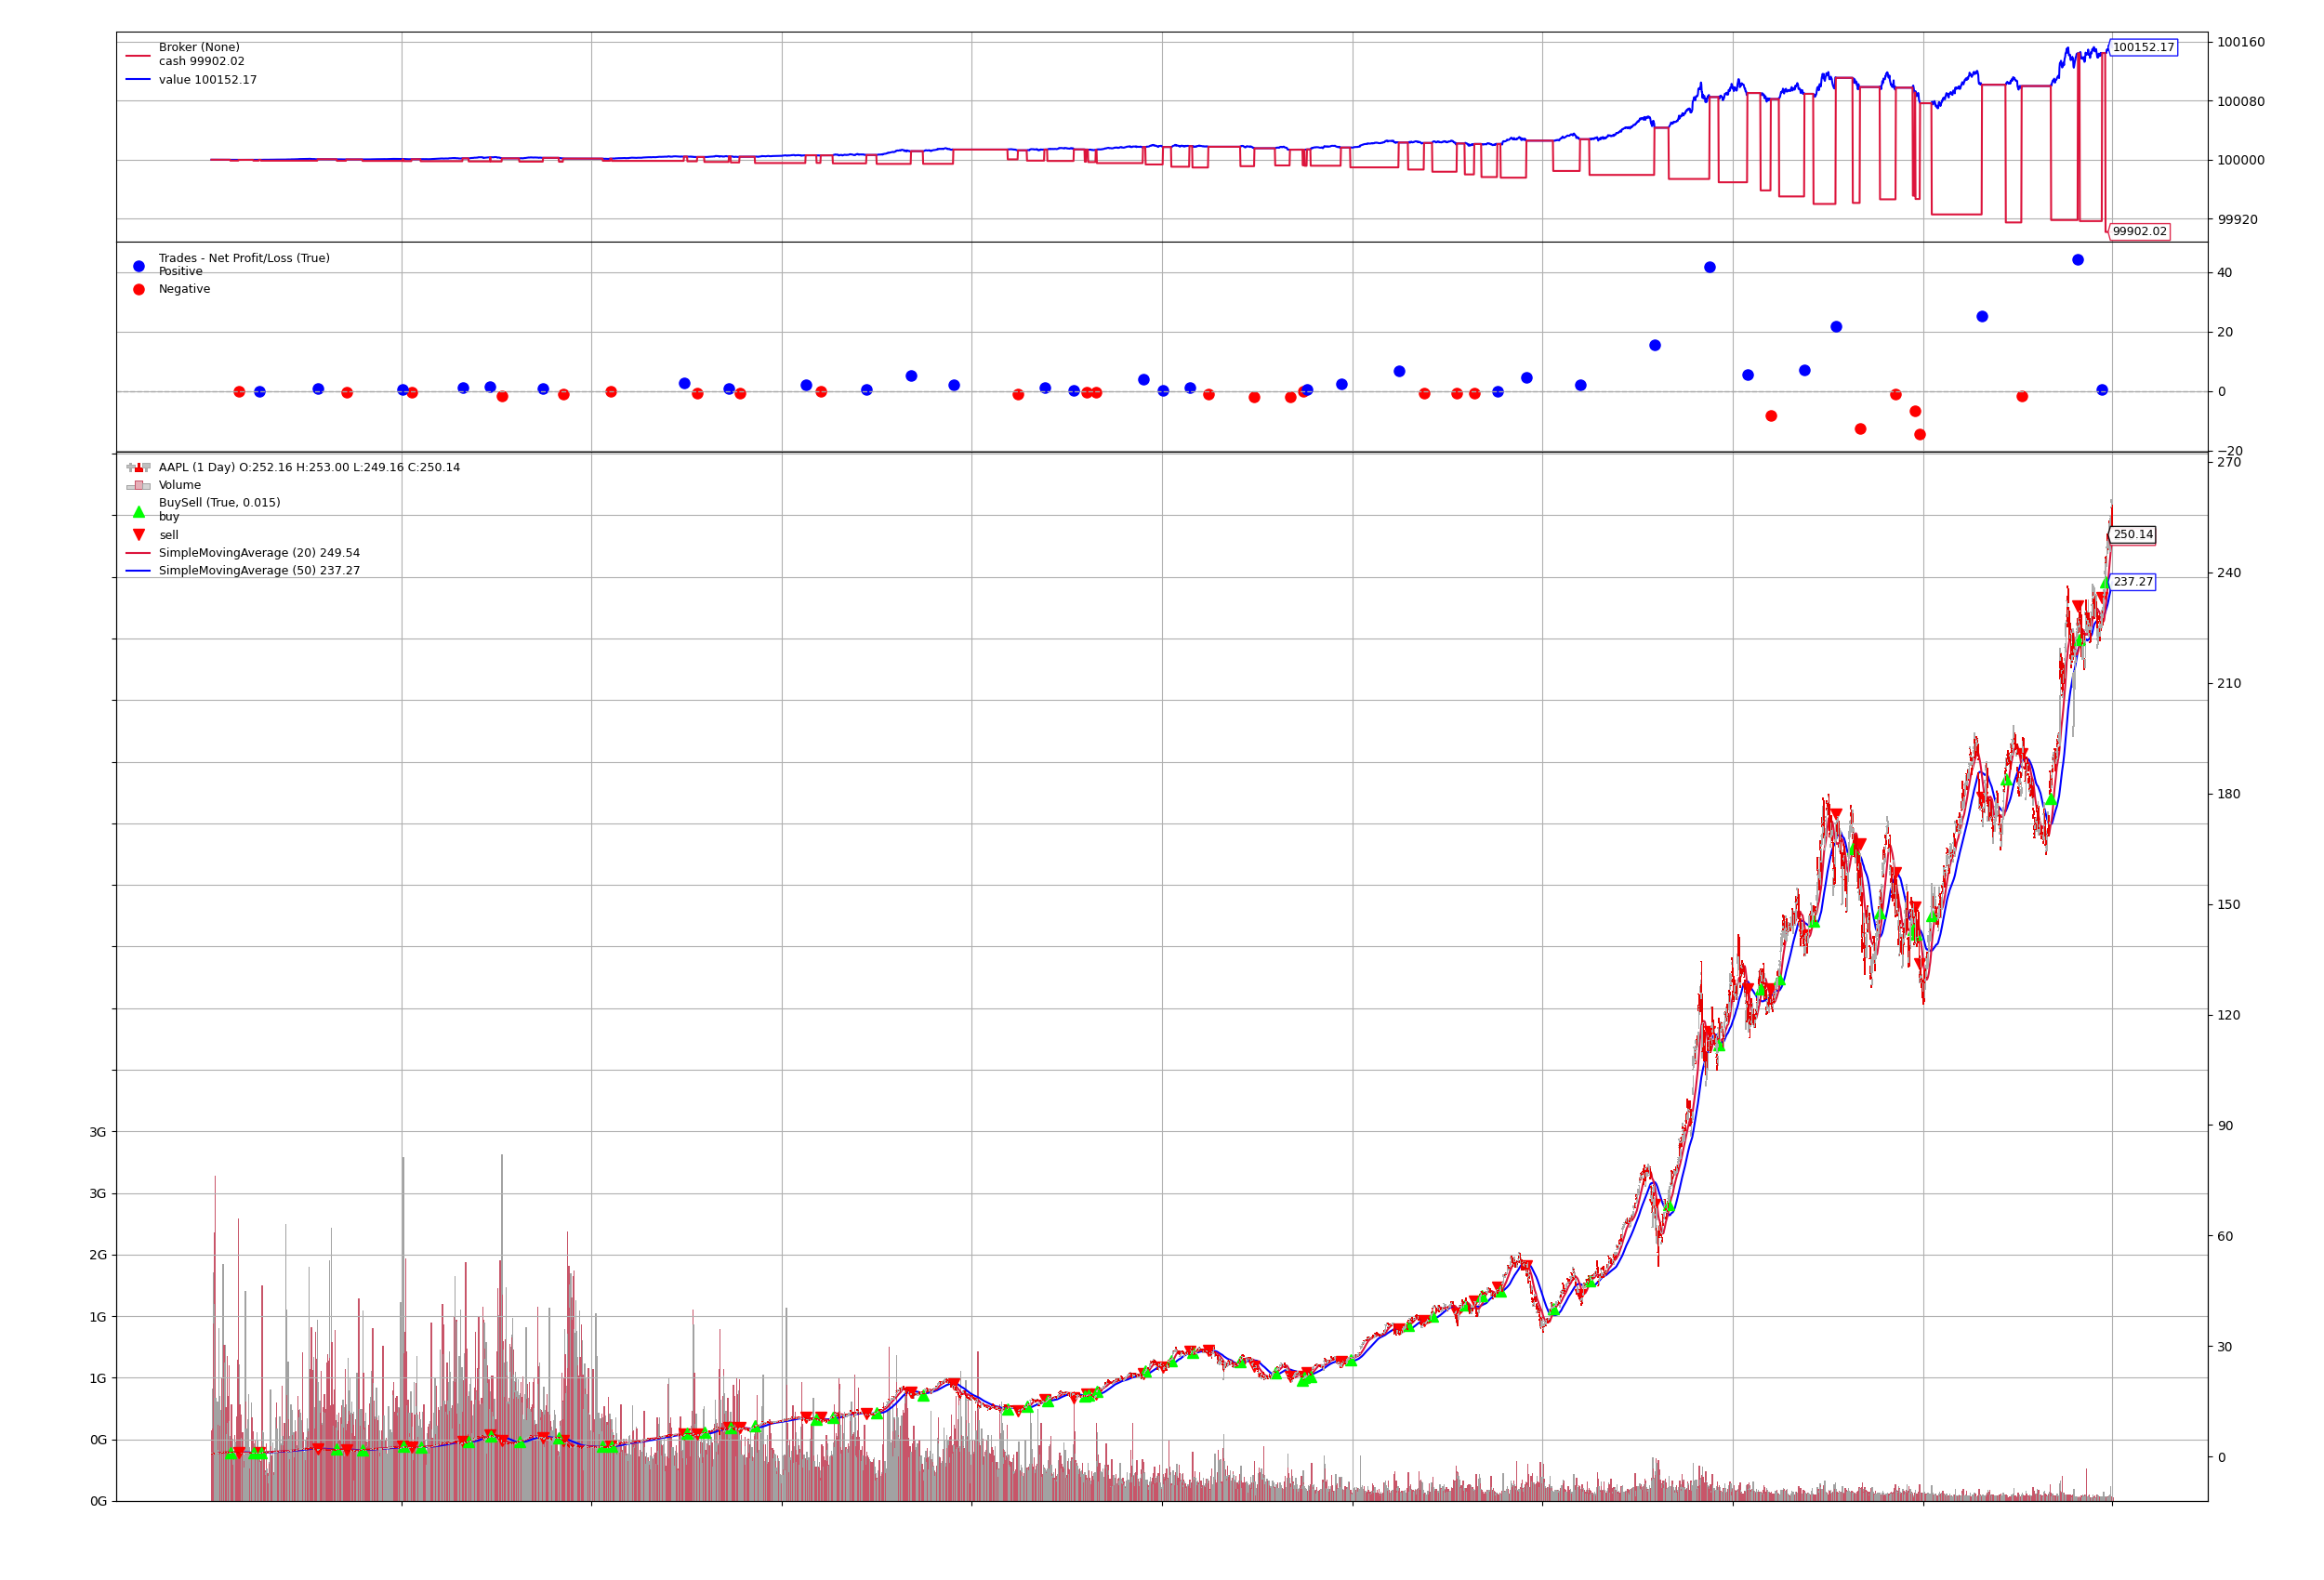

In [113]:
Image(img_path)

In [82]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)

for ticker, data in data_feeds:
    if (ticker == STOCK):
        cerebro.adddata(data, name=ticker)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")

print('Our Trading Strategy')
# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

sharpe_ratio = results[0].analyzers.sharpe.get_analysis()
drawdown = results[0].analyzers.drawdown.get_analysis()

img_path = "ourmodel.png"
save_plot(img_path)

print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Max Drawdown: {drawdown['max']['drawdown']}%")

Starting Portfolio Value: 100000.00
2010-01-04 ADBE Position 0
2010-01-04 AMD Position 0
2010-01-04 GOOGL Position 0
2010-01-04 GOOG Position 0
2010-01-04 AMZN Position 0
2010-01-04 AEP Position 0
2010-01-04 AMGN Position 0
2010-01-04 ADI Position 0
2010-01-04 ANSS Position 0
2010-01-04 AAPL Position 0
2010-01-04 AAPL Buy 823
2010-01-04 AMAT Position 0
2010-01-04 ASML Position 0
2010-01-04 AZN Position 0
2010-01-04 ADSK Position 0
2010-01-04 ADP Position 0
2010-01-04 AXON Position 0
2010-01-04 BKR Position 0
2010-01-04 BIIB Position 0
2010-01-04 BKNG Position 0
2010-01-04 AVGO Position 0
2010-01-04 CDNS Position 0
2010-01-04 CTAS Position 0
2010-01-04 CSCO Position 0
2010-01-04 CCEP Position 0
2010-01-04 CTSH Position 0
2010-01-04 CMCSA Position 0
2010-01-04 CPRT Position 0
2010-01-04 CSGP Position 0
2010-01-04 COST Position 0
2010-01-04 CSX Position 0
2010-01-04 DXCM Position 0
2010-01-04 EA Position 0
2010-01-04 EXC Position 0
2010-01-04 FAST Position 0
2010-01-04 FTNT Position 0
201

In [77]:
for i, d in enumerate(cerebro.datas):
    print(i, d._name, d.datetime.date())

0 ADBE 2010-12-31
1 AMD 2010-12-31


IndexError: array index out of range